In this notebook, we will analyze the Graph Convolutional Network (GCN) model that we trained in the previous notebook and explore some extensions and variations of the basic GCN architecture.

## Learning Objectives

By the end of this notebook, you should be able to:
1. Visualize and interpret node embeddings learned by GCNs
2. Analyze the effect of different hyperparameters on model performance
3. Implement extensions to the basic GCN architecture
4. Understand how GCNs capture graph structure through case studies

Let's begin by importing the necessary libraries.

In [17]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import time
import os
import sys
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid

# Add the current directory to path for importing utils
sys.path.append('.')
import utils

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Visualizing Node Embeddings

One of the advantages of GCNs is that they learn meaningful node embeddings that capture both feature information and graph structure. Let's visualize these embeddings to gain insights into what the model has learned.

### 1.1 Extracting Embeddings from a Trained Model

First, let's load our trained model and extract the embeddings from the second-to-last layer (before the classification layer):

In [18]:
import math
import utils

# GraphConvolution layer definition
class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

# Load dataset and model from previous notebook
adj, features, labels, idx_train, idx_val, idx_test = utils.load_data(dataset="cora")

# Convert to PyTorch tensors and move to device
features = utils.sparse_mx_to_torch_sparse_tensor(features).to(device)
adj = utils.sparse_mx_to_torch_sparse_tensor(utils.preprocess_adj(adj)).to(device)
labels = torch.LongTensor(labels).to(device)

# Define a modified GCN model that outputs intermediate embeddings
class GCN_with_embeddings(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout=0.5):
        super(GCN_with_embeddings, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj, return_embeddings=False):
        # First layer: feature transformation + graph convolution + ReLU + dropout
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        # If return_embeddings is True, return the embeddings from the hidden layer
        if return_embeddings:
            return x
        
        # Second layer: feature transformation + graph convolution + log softmax
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

# Initialize and load the model
model = GCN_with_embeddings(nfeat=features.shape[1], nhid=16, nclass=len(torch.unique(labels)), dropout=0.5).to(device)

# Load the best model weights if available, otherwise proceed with untrained model
try:
    model.load_state_dict(torch.load('best_model.pth'))
    print("Loaded trained model weights")
except:
    print("No trained model weights found, using untrained model")

# Extract embeddings
model.eval()
with torch.no_grad():
    embeddings = model(features, adj, return_embeddings=True).cpu().numpy()

print(f"Embeddings shape: {embeddings.shape}")

No trained model weights found, using untrained model
Embeddings shape: (2708, 16)


### 1.2 Visualizing with Dimensionality Reduction

Since the embeddings are in a high-dimensional space (16 dimensions in our case), we need to project them to 2D for visualization. We'll use t-SNE (t-Distributed Stochastic Neighbor Embedding), which is good at preserving local structure:

/home/jupyter-st125462/.local/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_110622/1813891781.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_classes)


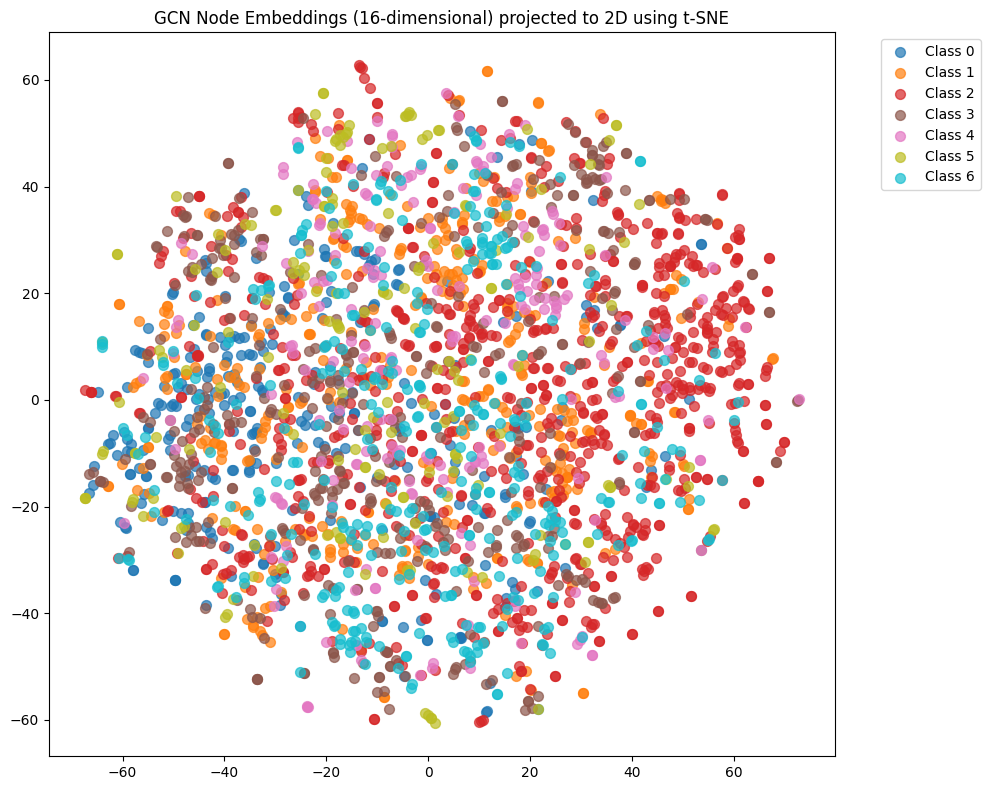

In [19]:
def visualize_embeddings_tsne(embeddings, labels, method='tsne', perplexity=30, n_iter=1000, title=None):
    """
    Visualize embeddings using t-SNE or PCA.
    
    Parameters
    ----------
    embeddings : numpy.ndarray
        Node embeddings
    labels : numpy.ndarray
        Node labels
    method : str, optional
        Dimensionality reduction method ('tsne' or 'pca')
    perplexity : int, optional
        Perplexity parameter for t-SNE
    n_iter : int, optional
        Number of iterations for t-SNE
    title : str, optional
        Plot title
        
    Returns
    -------
    matplotlib.figure.Figure
        The figure object
    """
    # Convert labels to numpy array if they are not already
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    
    # Apply dimensionality reduction
    if method.lower() == 'tsne':
        # t-SNE
        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)
        method_name = f"t-SNE (perplexity={perplexity}, iterations={n_iter})"
    elif method.lower() == 'pca':
        # PCA
        pca = PCA(n_components=2, random_state=42)
        embeddings_2d = pca.fit_transform(embeddings)
        method_name = "PCA"
    else:
        raise ValueError(f"Unknown method: {method}. Use 'tsne' or 'pca'.")
    
    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    
    # Get unique labels
    unique_labels = np.unique(labels)
    n_classes = len(unique_labels)
    
    # Create a colormap
    cmap = plt.cm.get_cmap('tab10', n_classes)
    
    # Plot each class
    for i, label in enumerate(unique_labels):
        mask = labels == label
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                    c=[cmap(i)], label=f'Class {label}', alpha=0.7, s=50)
    
    plt.title(title if title else f"Node Embeddings Visualization using {method_name}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

# Visualize embeddings
labels_np = labels.cpu().numpy()
visualize_embeddings_tsne(embeddings, labels_np, title="GCN Node Embeddings (16-dimensional) projected to 2D using t-SNE")
plt.show()

### 1.3 Analyzing Embedding Space

Let's analyze the embedding space to gain further insights:

Number of classes: 7
Average intra-class distance: 0.7277
Average inter-class distance: 0.2612
Ratio (inter/intra): 0.3589


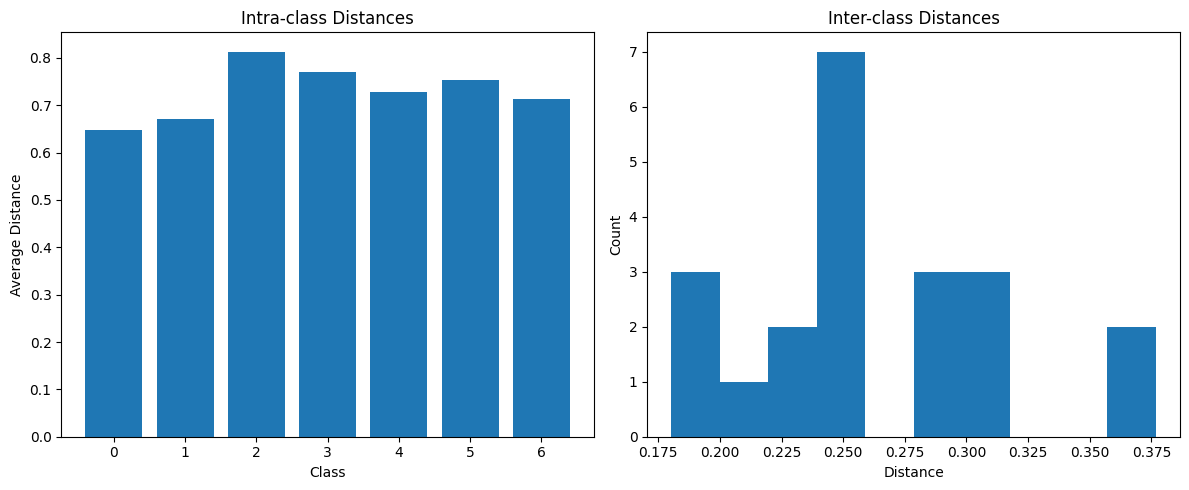

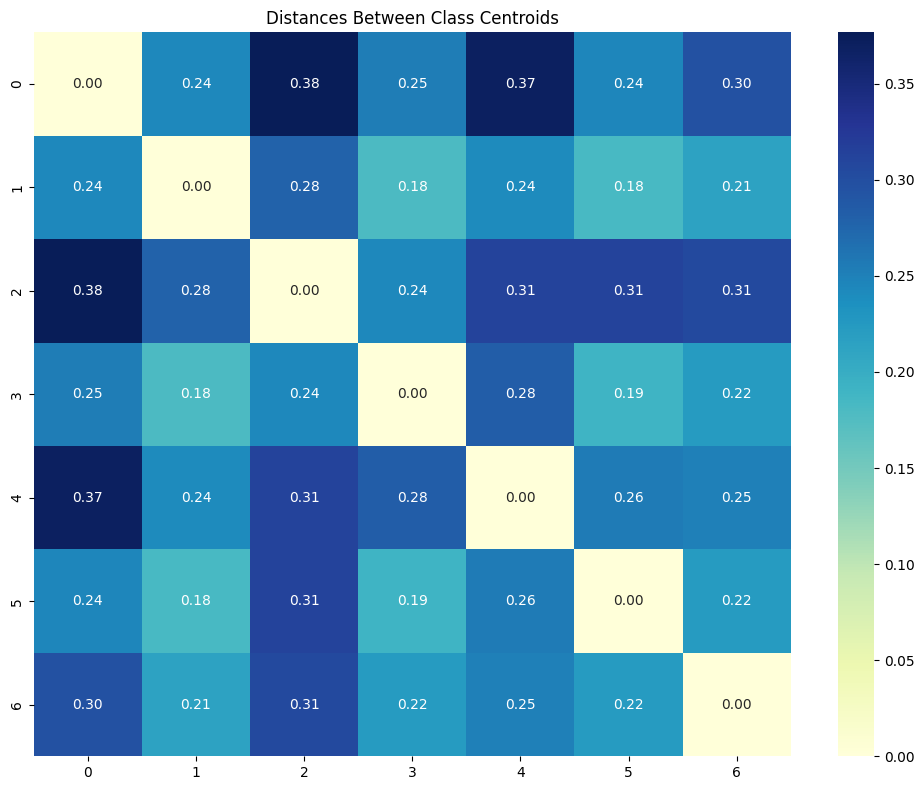

In [20]:
def analyze_embedding_space(embeddings, labels):
    """
    Analyze the embedding space.
    
    Parameters
    ----------
    embeddings : numpy.ndarray
        Node embeddings
    labels : numpy.ndarray
        Node labels
    """
    # Convert labels to numpy array if they are not already
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    
    # Calculate intra-class and inter-class distances
    unique_labels = np.unique(labels)
    n_classes = len(unique_labels)
    
    # Calculate centroid for each class
    centroids = []
    for label in unique_labels:
        mask = labels == label
        centroid = embeddings[mask].mean(axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)
    
    # Calculate average intra-class distance (distance to centroid)
    intra_class_distances = []
    for i, label in enumerate(unique_labels):
        mask = labels == label
        class_embeddings = embeddings[mask]
        centroid = centroids[i]
        
        # Calculate distances from each point to centroid
        distances = np.linalg.norm(class_embeddings - centroid, axis=1)
        intra_class_distances.append(np.mean(distances))
    
    # Calculate average inter-class distance (distance between centroids)
    inter_class_distances = []
    for i in range(n_classes):
        for j in range(i+1, n_classes):
            distance = np.linalg.norm(centroids[i] - centroids[j])
            inter_class_distances.append(distance)
    
    # Print statistics
    print(f"Number of classes: {n_classes}")
    print(f"Average intra-class distance: {np.mean(intra_class_distances):.4f}")
    print(f"Average inter-class distance: {np.mean(inter_class_distances):.4f}")
    print(f"Ratio (inter/intra): {np.mean(inter_class_distances) / np.mean(intra_class_distances):.4f}")
    
    # Plot distances
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(len(intra_class_distances)), intra_class_distances)
    plt.xlabel('Class')
    plt.ylabel('Average Distance')
    plt.title('Intra-class Distances')
    plt.xticks(range(len(intra_class_distances)), [f'{i}' for i in unique_labels])
    
    plt.subplot(1, 2, 2)
    plt.hist(inter_class_distances, bins=10)
    plt.xlabel('Distance')
    plt.ylabel('Count')
    plt.title('Inter-class Distances')
    
    plt.tight_layout()
    plt.show()
    
    # Create a heatmap of distances between class centroids
    plt.figure(figsize=(10, 8))
    centroid_distances = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(n_classes):
            centroid_distances[i, j] = np.linalg.norm(centroids[i] - centroids[j])
    
    sns.heatmap(centroid_distances, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=[f'{i}' for i in unique_labels],
                yticklabels=[f'{i}' for i in unique_labels])
    plt.title('Distances Between Class Centroids')
    plt.tight_layout()
    plt.show()

# Analyze the embedding space
analyze_embedding_space(embeddings, labels_np)

In this section, we'll systematically explore how different hyperparameters affect the performance of our GCN model. This is an important step in understanding the model's sensitivity and finding optimal configurations.

### 2.1 Hyperparameters to Explore

We'll analyze the effect of the following hyperparameters:
1. Hidden layer dimensions
2. Dropout rate
3. Learning rate
4. Weight decay (L2 regularization)
5. Number of GCN layers

Let's create a function to train and evaluate the GCN model with different hyperparameter configurations:

In [24]:
# Using Previously implemented GCN Architecture
class GCN(nn.Module):
    """
    Graph Convolutional Network with customizable depth.
    """
    def __init__(self, nfeat, nhid, nclass, dropout=0.5, num_layers=2):
        """
        Initialize the GCN model.
        
        Parameters
        ----------
        nfeat : int
            Number of input features
        nhid : int
            Number of hidden units
        nclass : int
            Number of classes (output dimension)
        dropout : float, optional
            Dropout rate
        num_layers : int, optional
            Number of GCN layers
        """
        super(GCN, self).__init__()
        
        self.dropout = dropout
        self.num_layers = num_layers
        
        # Create layers
        if num_layers == 1:
            # Single-layer GCN (rarely used in practice)
            self.layers = nn.ModuleList([GraphConvolution(nfeat, nclass)])
        else:
            # Multi-layer GCN
            self.layers = nn.ModuleList([
                GraphConvolution(nfeat, nhid)  # Input layer
            ])
            
            # Add hidden layers if more than 2 layers
            for i in range(num_layers - 2):
                self.layers.append(GraphConvolution(nhid, nhid))
                
            # Add output layer
            self.layers.append(GraphConvolution(nhid, nclass))

    def forward(self, x, adj):
        """
        Forward pass of the GCN model.
        
        Parameters
        ----------
        x : torch.Tensor
            Input features
        adj : torch.sparse.FloatTensor
            Normalized adjacency matrix
            
        Returns
        -------
        torch.Tensor
            Output predictions
        """
        # Forward pass through all layers except the last one
        for i in range(self.num_layers - 1):
            x = self.layers[i](x, adj)
            x = F.relu(x)  # Apply ReLU activation
            x = F.dropout(x, self.dropout, training=self.training)  # Apply dropout
        
        # Final layer (no activation or dropout)
        x = self.layers[-1](x, adj)
        
        return F.log_softmax(x, dim=1)  # Apply log softmax for classification

In [25]:
def train_and_evaluate_gcn(features, adj, labels, idx_train, idx_val, idx_test, 
                          hidden_dims, dropout, lr, weight_decay, num_layers,
                          epochs=200, early_stopping_patience=10, verbose=False):
    """
    Train and evaluate a GCN model with the specified hyperparameters.
    
    Parameters
    ----------
    features : torch.sparse.FloatTensor
        Input features
    adj : torch.sparse.FloatTensor
        Normalized adjacency matrix
    labels : torch.LongTensor
        Node labels
    idx_train : torch.LongTensor
        Indices of training nodes
    idx_val : torch.LongTensor
        Indices of validation nodes
    idx_test : torch.LongTensor
        Indices of test nodes
    hidden_dims : int
        Dimension of hidden layers
    dropout : float
        Dropout rate
    lr : float
        Learning rate
    weight_decay : float
        Weight decay (L2 regularization)
    num_layers : int
        Number of GCN layers
    epochs : int, optional
        Maximum number of epochs
    early_stopping_patience : int, optional
        Number of epochs to wait for improvement before early stopping
    verbose : bool, optional
        Whether to print progress
        
    Returns
    -------
    dict
        Results including validation and test accuracy
    """
    # Set seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Initialize model
    model = GCN(nfeat=features.shape[1],
               nhid=hidden_dims,
               nclass=len(torch.unique(labels)),
               dropout=dropout,
               num_layers=num_layers).to(device)
    
    # Define loss function and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Variables for early stopping
    best_val_acc = 0
    best_epoch = 0
    counter = 0
    best_model = None
    
    # Training loop
    for epoch in range(epochs):
        # Train
        model.train()
        optimizer.zero_grad()
        output = model(features, adj)
        loss = criterion(output[idx_train], labels[idx_train])
        loss.backward()
        optimizer.step()
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            output = model(features, adj)
            
            # Validation
            val_loss = criterion(output[idx_val], labels[idx_val])
            _, val_preds = output[idx_val].max(1)
            val_acc = val_preds.eq(labels[idx_val]).double().sum() / len(idx_val)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Val Acc: {val_acc.item():.4f}")
            
            # Check for improvement
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch
                counter = 0
                # Save best model state
                best_model = model.state_dict().copy()
            else:
                counter += 1
            
            # Early stopping
            if counter >= early_stopping_patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1}. Best val acc: {best_val_acc:.4f} at epoch {best_epoch+1}")
                break
    
    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        output = model(features, adj)
        
        # Validation accuracy
        _, val_preds = output[idx_val].max(1)
        val_acc = val_preds.eq(labels[idx_val]).double().sum() / len(idx_val)
        
        # Test accuracy
        _, test_preds = output[idx_test].max(1)
        test_acc = test_preds.eq(labels[idx_test]).double().sum() / len(idx_test)
    
    return {
        'val_acc': val_acc.item(),
        'test_acc': test_acc.item(),
        'best_epoch': best_epoch,
        'hidden_dims': hidden_dims,
        'dropout': dropout,
        'lr': lr,
        'weight_decay': weight_decay,
        'num_layers': num_layers
    }

### 2.2 Grid Search for Hyperparameter Tuning

Let's perform a grid search to systematically explore different hyperparameter combinations:

In [26]:
def hyperparameter_grid_search(features, adj, labels, idx_train, idx_val, idx_test):
    """
    Perform a grid search to find the best hyperparameters.
    
    Parameters
    ----------
    features : torch.sparse.FloatTensor
        Input features
    adj : torch.sparse.FloatTensor
        Normalized adjacency matrix
    labels : torch.LongTensor
        Node labels
    idx_train : torch.LongTensor
        Indices of training nodes
    idx_val : torch.LongTensor
        Indices of validation nodes
    idx_test : torch.LongTensor
        Indices of test nodes
        
    Returns
    -------
    list
        Results for each hyperparameter configuration
    """
    # Define hyperparameter grid
    param_grid = {
        'hidden_dims': [8, 16, 32, 64],
        'dropout': [0.3, 0.5, 0.7],
        'lr': [0.001, 0.01, 0.05],
        'weight_decay': [5e-5, 5e-4, 5e-3],
        'num_layers': [2, 3]
    }
    
    # Generate all combinations of hyperparameters
    grid = list(ParameterGrid(param_grid))
    print(f"Total number of configurations: {len(grid)}")
    
    # Initialize results list
    results = []
    
    # Run grid search
    for i, params in enumerate(tqdm(grid, desc="Grid Search")):
        print(f"\nConfiguration {i+1}/{len(grid)}: {params}")
        
        # Train and evaluate model with current configuration
        result = train_and_evaluate_gcn(
            features, adj, labels, idx_train, idx_val, idx_test,
            hidden_dims=params['hidden_dims'],
            dropout=params['dropout'],
            lr=params['lr'],
            weight_decay=params['weight_decay'],
            num_layers=params['num_layers'],
            verbose=False
        )
        
        # Add result to list
        results.append(result)
        
        # Print result
        print(f"Val Acc: {result['val_acc']:.4f}, Test Acc: {result['test_acc']:.4f}, Best Epoch: {result['best_epoch']+1}")
    
    return results

# Uncomment to run the grid search (this will take a long time!)
grid_search_results = hyperparameter_grid_search(features, adj, labels, idx_train, idx_val, idx_test)

Total number of configurations: 216


Grid Search:   0%|          | 0/216 [00:00<?, ?it/s]


Configuration 1/216: {'dropout': 0.3, 'hidden_dims': 8, 'lr': 0.001, 'num_layers': 2, 'weight_decay': 5e-05}
Val Acc: 0.7720, Test Acc: 0.6450, Best Epoch: 200

Configuration 2/216: {'dropout': 0.3, 'hidden_dims': 8, 'lr': 0.001, 'num_layers': 2, 'weight_decay': 0.0005}
Val Acc: 0.7680, Test Acc: 0.6470, Best Epoch: 199

Configuration 3/216: {'dropout': 0.3, 'hidden_dims': 8, 'lr': 0.001, 'num_layers': 2, 'weight_decay': 0.005}
Val Acc: 0.7140, Test Acc: 0.5910, Best Epoch: 200

Configuration 4/216: {'dropout': 0.3, 'hidden_dims': 8, 'lr': 0.001, 'num_layers': 3, 'weight_decay': 5e-05}
Val Acc: 0.4320, Test Acc: 0.3520, Best Epoch: 46

Configuration 5/216: {'dropout': 0.3, 'hidden_dims': 8, 'lr': 0.001, 'num_layers': 3, 'weight_decay': 0.0005}
Val Acc: 0.5700, Test Acc: 0.4850, Best Epoch: 103

Configuration 6/216: {'dropout': 0.3, 'hidden_dims': 8, 'lr': 0.001, 'num_layers': 3, 'weight_decay': 0.005}
Val Acc: 0.5900, Test Acc: 0.5120, Best Epoch: 162

Configuration 7/216: {'dropout':

Since a full grid search can be very time-consuming, let's do a more focused analysis by varying one hyperparameter at a time:

### 2.3 Analyzing Individual Hyperparameters

In [27]:
def analyze_individual_hyperparameters(features, adj, labels, idx_train, idx_val, idx_test):
    """
    Analyze the effect of individual hyperparameters on model performance.
    
    Parameters
    ----------
    features : torch.sparse.FloatTensor
        Input features
    adj : torch.sparse.FloatTensor
        Normalized adjacency matrix
    labels : torch.LongTensor
        Node labels
    idx_train : torch.LongTensor
        Indices of training nodes
    idx_val : torch.LongTensor
        Indices of validation nodes
    idx_test : torch.LongTensor
        Indices of test nodes
        
    Returns
    -------
    dict
        Results for each hyperparameter analysis
    """
    # Base configuration (from paper)
    base_config = {
        'hidden_dims': 16,
        'dropout': 0.5,
        'lr': 0.01,
        'weight_decay': 5e-4,
        'num_layers': 2
    }
    
    # Define ranges for each hyperparameter
    hidden_dims_range = [4, 8, 16, 32, 64, 128]
    dropout_range = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8]
    lr_range = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
    weight_decay_range = [0, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3]
    num_layers_range = [1, 2, 3, 4, 5]
    
    results = {
        'hidden_dims': [],
        'dropout': [],
        'lr': [],
        'weight_decay': [],
        'num_layers': []
    }
    
    # Analyze hidden dimensions
    print("Analyzing hidden dimensions...")
    for hidden_dims in tqdm(hidden_dims_range):
        result = train_and_evaluate_gcn(
            features, adj, labels, idx_train, idx_val, idx_test,
            hidden_dims=hidden_dims,
            dropout=base_config['dropout'],
            lr=base_config['lr'],
            weight_decay=base_config['weight_decay'],
            num_layers=base_config['num_layers']
        )
        results['hidden_dims'].append(result)
    
    # Analyze dropout
    print("\nAnalyzing dropout...")
    for dropout in tqdm(dropout_range):
        result = train_and_evaluate_gcn(
            features, adj, labels, idx_train, idx_val, idx_test,
            hidden_dims=base_config['hidden_dims'],
            dropout=dropout,
            lr=base_config['lr'],
            weight_decay=base_config['weight_decay'],
            num_layers=base_config['num_layers']
        )
        results['dropout'].append(result)
    
    # Analyze learning rate
    print("\nAnalyzing learning rate...")
    for lr in tqdm(lr_range):
        result = train_and_evaluate_gcn(
            features, adj, labels, idx_train, idx_val, idx_test,
            hidden_dims=base_config['hidden_dims'],
            dropout=base_config['dropout'],
            lr=lr,
            weight_decay=base_config['weight_decay'],
            num_layers=base_config['num_layers']
        )
        results['lr'].append(result)
    
    # Analyze weight decay
    print("\nAnalyzing weight decay...")
    for weight_decay in tqdm(weight_decay_range):
        result = train_and_evaluate_gcn(
            features, adj, labels, idx_train, idx_val, idx_test,
            hidden_dims=base_config['hidden_dims'],
            dropout=base_config['dropout'],
            lr=base_config['lr'],
            weight_decay=weight_decay,
            num_layers=base_config['num_layers']
        )
        results['weight_decay'].append(result)
    
    # Analyze number of layers
    print("\nAnalyzing number of layers...")
    for num_layers in tqdm(num_layers_range):
        result = train_and_evaluate_gcn(
            features, adj, labels, idx_train, idx_val, idx_test,
            hidden_dims=base_config['hidden_dims'],
            dropout=base_config['dropout'],
            lr=base_config['lr'],
            weight_decay=base_config['weight_decay'],
            num_layers=num_layers
        )
        results['num_layers'].append(result)
    
    return results

# Uncomment to run the hyperparameter analysis (this will take some time)
hyperparameter_analysis_results = analyze_individual_hyperparameters(features, adj, labels, idx_train, idx_val, idx_test)

Analyzing hidden dimensions...


  0%|          | 0/6 [00:00<?, ?it/s]


Analyzing dropout...


  0%|          | 0/6 [00:00<?, ?it/s]


Analyzing learning rate...


  0%|          | 0/6 [00:00<?, ?it/s]


Analyzing weight decay...


  0%|          | 0/6 [00:00<?, ?it/s]


Analyzing number of layers...


  0%|          | 0/5 [00:00<?, ?it/s]

### 2.4 Visualizing Hyperparameter Effects

We can visualize the effects of different hyperparameters on model performance:

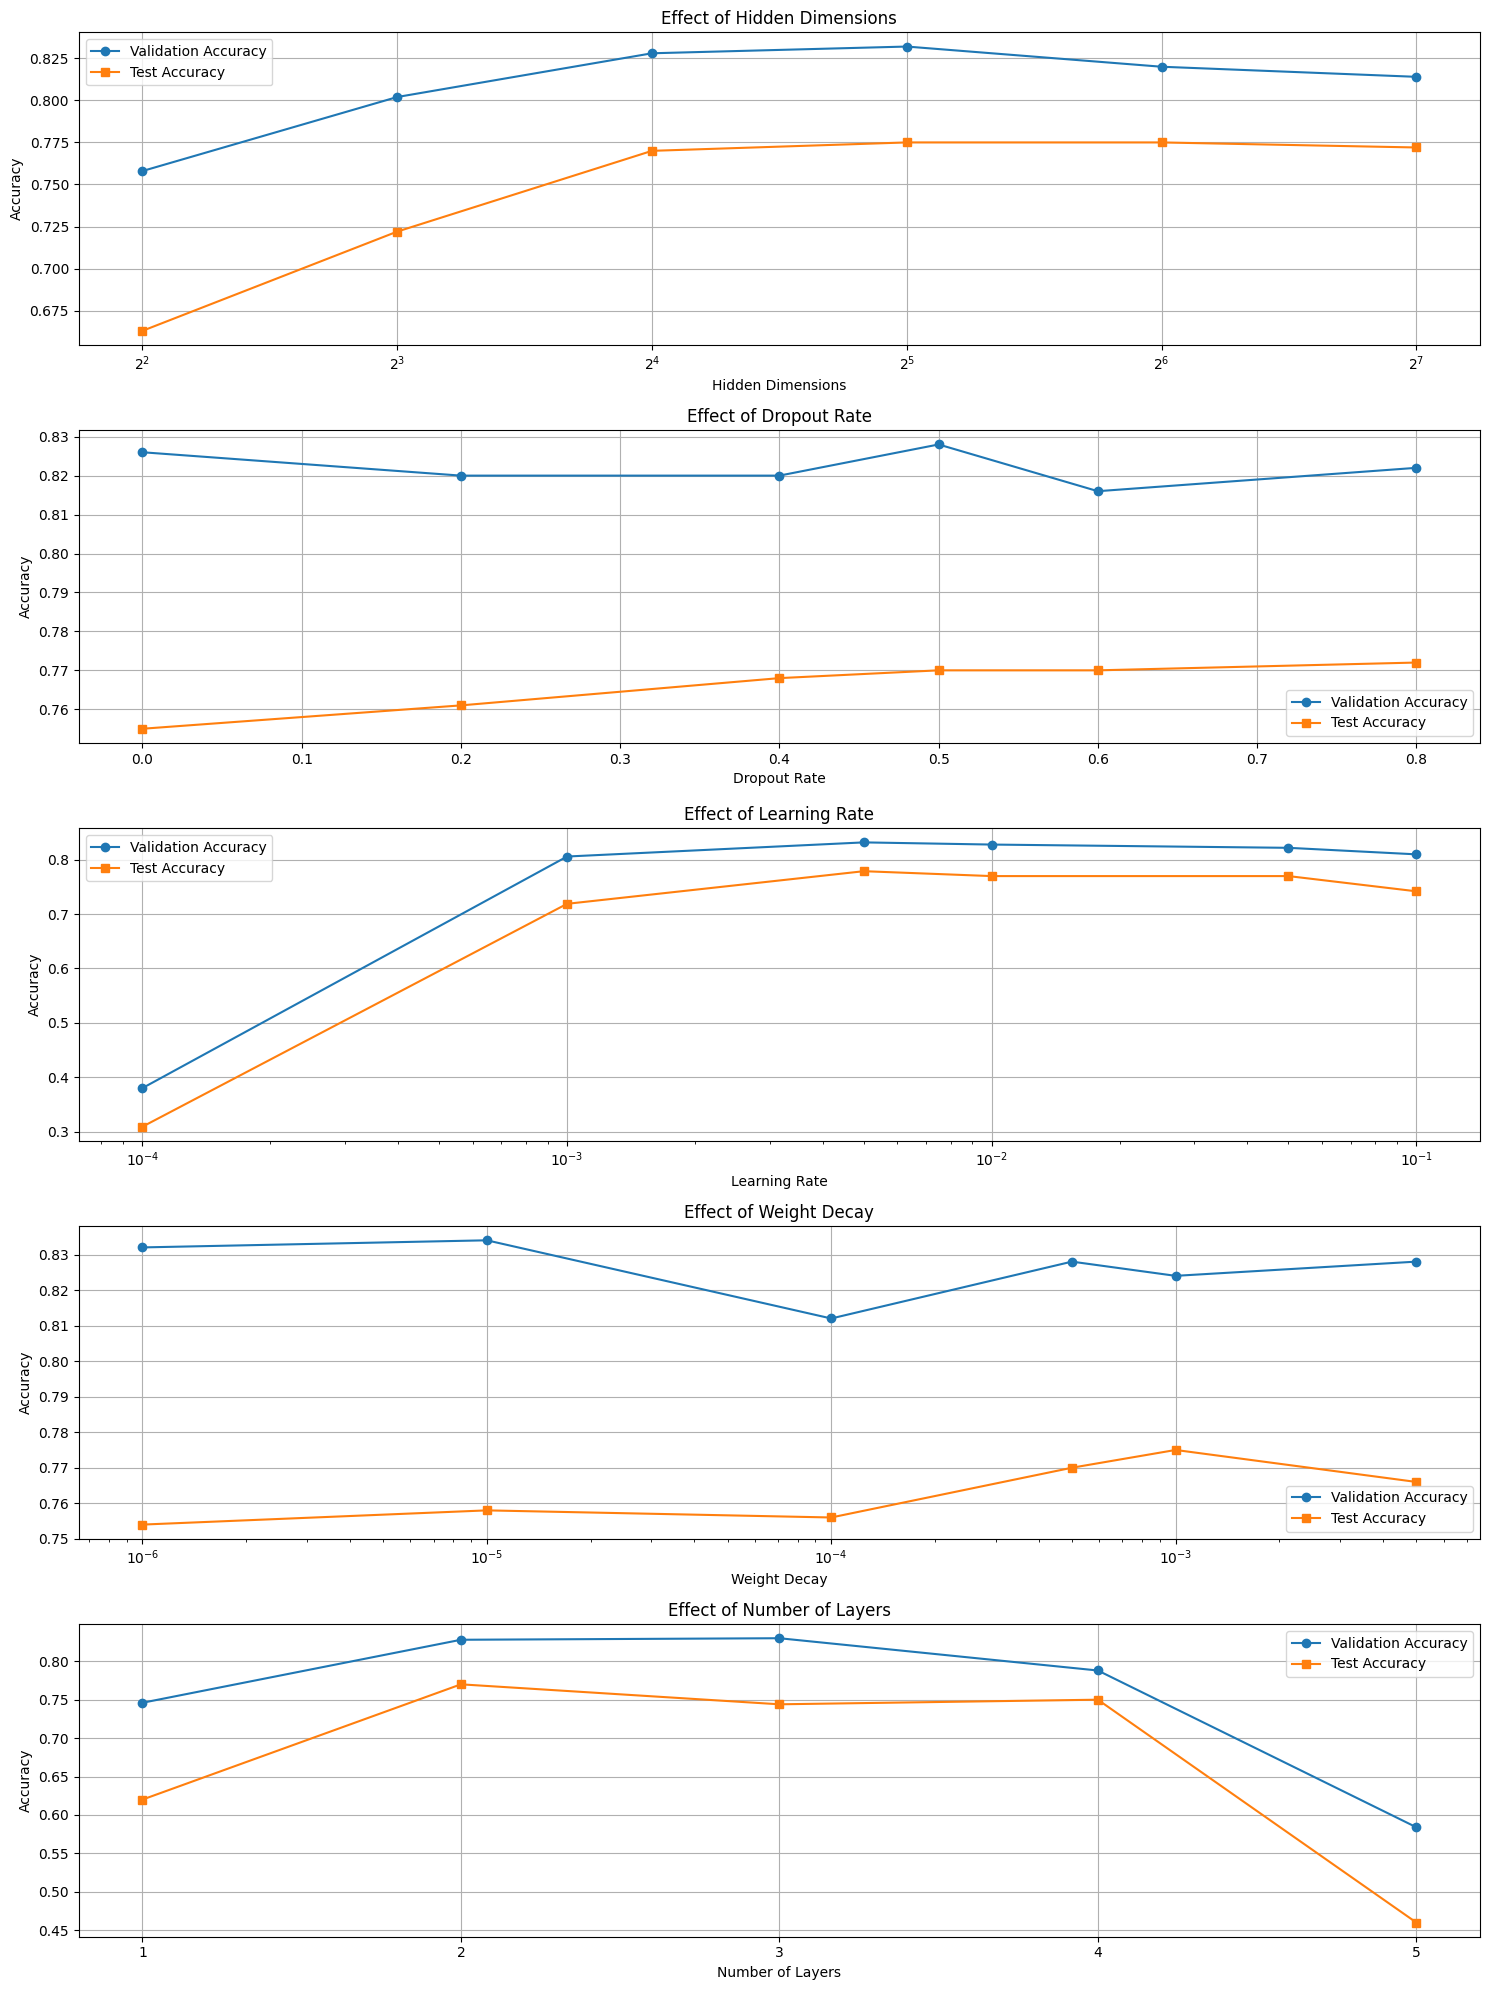

In [28]:
def plot_hyperparameter_effects(results):
    """
    Plot the effects of different hyperparameters on model performance.
    
    Parameters
    ----------
    results : dict
        Results from hyperparameter analysis
    """
    plt.figure(figsize=(15, 20))
    
    # Plot hidden dimensions
    plt.subplot(5, 1, 1)
    hidden_dims = [r['hidden_dims'] for r in results['hidden_dims']]
    val_accs = [r['val_acc'] for r in results['hidden_dims']]
    test_accs = [r['test_acc'] for r in results['hidden_dims']]
    
    plt.plot(hidden_dims, val_accs, 'o-', label='Validation Accuracy')
    plt.plot(hidden_dims, test_accs, 's-', label='Test Accuracy')
    plt.xscale('log', base=2)
    plt.xlabel('Hidden Dimensions')
    plt.ylabel('Accuracy')
    plt.title('Effect of Hidden Dimensions')
    plt.grid(True)
    plt.legend()
    
    # Plot dropout
    plt.subplot(5, 1, 2)
    dropout_rates = [r['dropout'] for r in results['dropout']]
    val_accs = [r['val_acc'] for r in results['dropout']]
    test_accs = [r['test_acc'] for r in results['dropout']]
    
    plt.plot(dropout_rates, val_accs, 'o-', label='Validation Accuracy')
    plt.plot(dropout_rates, test_accs, 's-', label='Test Accuracy')
    plt.xlabel('Dropout Rate')
    plt.ylabel('Accuracy')
    plt.title('Effect of Dropout Rate')
    plt.grid(True)
    plt.legend()
    
    # Plot learning rate
    plt.subplot(5, 1, 3)
    learning_rates = [r['lr'] for r in results['lr']]
    val_accs = [r['val_acc'] for r in results['lr']]
    test_accs = [r['test_acc'] for r in results['lr']]
    
    plt.plot(learning_rates, val_accs, 'o-', label='Validation Accuracy')
    plt.plot(learning_rates, test_accs, 's-', label='Test Accuracy')
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.title('Effect of Learning Rate')
    plt.grid(True)
    plt.legend()
    
    # Plot weight decay
    plt.subplot(5, 1, 4)
    weight_decays = [r['weight_decay'] for r in results['weight_decay']]
    val_accs = [r['val_acc'] for r in results['weight_decay']]
    test_accs = [r['test_acc'] for r in results['weight_decay']]
    
    # Replace 0 with a small value for log scale
    weight_decays_log = [wd if wd > 0 else 1e-6 for wd in weight_decays]
    
    plt.plot(weight_decays_log, val_accs, 'o-', label='Validation Accuracy')
    plt.plot(weight_decays_log, test_accs, 's-', label='Test Accuracy')
    plt.xscale('log')
    plt.xlabel('Weight Decay')
    plt.ylabel('Accuracy')
    plt.title('Effect of Weight Decay')
    plt.grid(True)
    plt.legend()
    
    # Plot number of layers
    plt.subplot(5, 1, 5)
    num_layers = [r['num_layers'] for r in results['num_layers']]
    val_accs = [r['val_acc'] for r in results['num_layers']]
    test_accs = [r['test_acc'] for r in results['num_layers']]
    
    plt.plot(num_layers, val_accs, 'o-', label='Validation Accuracy')
    plt.plot(num_layers, test_accs, 's-', label='Test Accuracy')
    plt.xlabel('Number of Layers')
    plt.ylabel('Accuracy')
    plt.title('Effect of Number of Layers')
    plt.xticks(num_layers)
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Assuming we have the results from the previous analysis
plot_hyperparameter_effects(hyperparameter_analysis_results)

### 2.5 Finding the Best Configuration

Based on our analysis, we can determine the best hyperparameter configuration:

In [30]:
def find_best_configuration(results):
    """
    Find the best hyperparameter configuration based on validation accuracy.
    
    Parameters
    ----------
    results : dict
        Results from hyperparameter analysis
        
    Returns
    -------
    dict
        Best configuration for each hyperparameter
    """
    best_config = {}
    
    # Find best hidden dimensions
    best_val_acc = 0
    best_hidden_dims = None
    for r in results['hidden_dims']:
        if r['val_acc'] > best_val_acc:
            best_val_acc = r['val_acc']
            best_hidden_dims = r['hidden_dims']
    best_config['hidden_dims'] = best_hidden_dims
    
    # Find best dropout
    best_val_acc = 0
    best_dropout = None
    for r in results['dropout']:
        if r['val_acc'] > best_val_acc:
            best_val_acc = r['val_acc']
            best_dropout = r['dropout']
    best_config['dropout'] = best_dropout
    
    # Find best learning rate
    best_val_acc = 0
    best_lr = None
    for r in results['lr']:
        if r['val_acc'] > best_val_acc:
            best_val_acc = r['val_acc']
            best_lr = r['lr']
    best_config['lr'] = best_lr
    
    # Find best weight decay
    best_val_acc = 0
    best_weight_decay = None
    for r in results['weight_decay']:
        if r['val_acc'] > best_val_acc:
            best_val_acc = r['val_acc']
            best_weight_decay = r['weight_decay']
    best_config['weight_decay'] = best_weight_decay
    
    # Find best number of layers
    best_val_acc = 0
    best_num_layers = None
    for r in results['num_layers']:
        if r['val_acc'] > best_val_acc:
            best_val_acc = r['val_acc']
            best_num_layers = r['num_layers']
    best_config['num_layers'] = best_num_layers
    
    print("Best Configuration:")
    print(f"Hidden Dimensions: {best_config['hidden_dims']}")
    print(f"Dropout: {best_config['dropout']}")
    print(f"Learning Rate: {best_config['lr']}")
    print(f"Weight Decay: {best_config['weight_decay']}")
    print(f"Number of Layers: {best_config['num_layers']}")
    
    return best_config

# Assuming we have the results from the previous analysis
best_config = find_best_configuration(hyperparameter_analysis_results)

Best Configuration:
Hidden Dimensions: 32
Dropout: 0.5
Learning Rate: 0.005
Weight Decay: 1e-05
Number of Layers: 3


In this section, we'll explore some extensions and variations of the basic GCN architecture that can improve performance or address specific challenges.

### 3.1 Understanding the Limitations of GCNs

Before we dive into extensions, let's understand some limitations of the basic GCN model:

1. **Over-smoothing**: As we stack more layers, node features tend to become similar, making it difficult to distinguish between different classes.
2. **Scalability**: The standard GCN operates on the entire graph, which can be computationally expensive for very large graphs.
3. **Fixed graph structure**: The standard GCN assumes a fixed graph structure, which may not be optimal for the task.
4. **Limited receptive field**: Each GCN layer only aggregates information from immediate neighbors.

Let's address some of these limitations with extensions to the basic GCN architecture.

### 3.2 Residual Connections for Deep GCNs

One way to alleviate the over-smoothing problem is to use residual connections, similar to ResNet in computer vision:

In [31]:
class ResGCNLayer(nn.Module):
    """
    Residual Graph Convolutional Layer
    """
    def __init__(self, in_features, out_features):
        super(ResGCNLayer, self).__init__()
        self.gc = GraphConvolution(in_features, out_features)
        
        # If dimensions don't match, add a linear projection
        self.use_projection = (in_features != out_features)
        if self.use_projection:
            self.projection = nn.Linear(in_features, out_features)
    
    def forward(self, x, adj):
        identity = x
        out = self.gc(x, adj)
        
        # If dimensions don't match, apply projection
        if self.use_projection:
            identity = self.projection(identity)
        
        # Add residual connection
        out = out + identity
        return out

class ResGCN(nn.Module):
    """
    Residual Graph Convolutional Network
    """
    def __init__(self, nfeat, nhid, nclass, num_layers=2, dropout=0.5):
        super(ResGCN, self).__init__()
        self.dropout = dropout
        
        # First layer
        self.gc1 = GraphConvolution(nfeat, nhid)
        
        # Middle layers with residual connections
        self.res_layers = nn.ModuleList([
            ResGCNLayer(nhid, nhid) for _ in range(num_layers - 2)
        ])
        
        # Output layer
        self.gc_out = GraphConvolution(nhid, nclass)
    
    def forward(self, x, adj):
        # First layer
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        # Middle layers with residual connections
        for layer in self.res_layers:
            x = F.relu(layer(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)
        
        # Output layer
        x = self.gc_out(x, adj)
        return F.log_softmax(x, dim=1)

### 3.3 GraphSAGE: Scaling to Large Graphs

GraphSAGE (Graph Sample and Aggregate) is an extension of GCN that enables inductive learning and scales to large graphs by sampling a fixed number of neighbors for each node:

In [32]:
class SAGEConv(nn.Module):
    """
    GraphSAGE Convolution Layer
    """
    def __init__(self, in_features, out_features, aggregator_type='mean'):
        super(SAGEConv, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Linear transformation for self features
        self.linear_self = nn.Linear(in_features, out_features)
        
        # Linear transformation for neighbor features
        self.linear_neigh = nn.Linear(in_features, out_features)
        
        # Aggregator type
        self.aggregator_type = aggregator_type
    
    def forward(self, x, adj):
        """
        Forward pass with mean aggregation.
        
        Parameters
        ----------
        x : torch.Tensor
            Node features (N x in_features)
        adj : torch.sparse.FloatTensor
            Normalized adjacency matrix
            
        Returns
        -------
        torch.Tensor
            Updated node features (N x out_features)
        """
        # Self transformation
        out_self = self.linear_self(x)
        
        # Neighbor aggregation
        if self.aggregator_type == 'mean':
            # Mean aggregation using the normalized adjacency matrix
            out_neigh = self.linear_neigh(torch.spmm(adj, x))
        elif self.aggregator_type == 'max':
            # Max aggregation (simplified for demonstration)
            # In practice, this would require a more complex implementation with sampled neighbors
            raise NotImplementedError("Max aggregation not implemented in this example")
        else:
            raise ValueError(f"Unknown aggregator type: {self.aggregator_type}")
        
        # Combine self and neighbor information
        out = out_self + out_neigh
        
        # Apply normalization (as in the original GraphSAGE paper)
        out = F.normalize(out, p=2, dim=1)
        
        return out

class GraphSAGE(nn.Module):
    """
    GraphSAGE Network
    """
    def __init__(self, nfeat, nhid, nclass, num_layers=2, dropout=0.5, aggregator_type='mean'):
        super(GraphSAGE, self).__init__()
        self.dropout = dropout
        
        # First layer
        self.conv1 = SAGEConv(nfeat, nhid, aggregator_type)
        
        # Middle layers
        self.convs = nn.ModuleList([
            SAGEConv(nhid, nhid, aggregator_type) for _ in range(num_layers - 2)
        ])
        
        # Output layer
        self.conv_out = nn.Linear(nhid, nclass)
    
    def forward(self, x, adj):
        # First layer
        x = F.relu(self.conv1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        # Middle layers
        for conv in self.convs:
            x = F.relu(conv(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)
        
        # Output layer
        x = self.conv_out(x)
        return F.log_softmax(x, dim=1)

### 3.4 Comparing Different GNN Architectures

Let's compare the performance of the different GNN architectures on the Cora dataset:

In [37]:
def compare_gnn_architectures(features, adj, labels, idx_train, idx_val, idx_test):
    """
    Compare different GNN architectures.
    
    Parameters
    ----------
    features : torch.sparse.FloatTensor
        Input features
    adj : torch.sparse.FloatTensor
        Normalized adjacency matrix
    labels : torch.LongTensor
        Node labels
    idx_train : torch.LongTensor
        Indices of training nodes
    idx_val : torch.LongTensor
        Indices of validation nodes
    idx_test : torch.LongTensor
        Indices of test nodes
        
    Returns
    -------
    dict
        Results for each architecture
    """
    # Set seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Define common parameters
    nfeat = features.shape[1]
    nhid = 16
    nclass = len(torch.unique(labels))
    dropout = 0.5
    epochs = 200
    early_stopping_patience = 10
    
    # Define models
    models = {
        'GCN': GCN(nfeat=nfeat, nhid=nhid, nclass=nclass, dropout=dropout),
        'ResGCN': ResGCN(nfeat=nfeat, nhid=nhid, nclass=nclass, dropout=dropout, num_layers=3),
        'GraphSAGE': GraphSAGE(nfeat=nfeat, nhid=nhid, nclass=nclass, dropout=dropout),
    }
    
    # Define loss function and optimizers
    criterion = nn.NLLLoss()
    optimizers = {
        name: optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        for name, model in models.items()
    }
    
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model = model.to(device)
        optimizer = optimizers[name]
        
        # Variables for early stopping
        best_val_acc = 0
        best_epoch = 0
        counter = 0
        best_model = None
        
        # Training loop
        for epoch in range(epochs):
            # Train
            model.train()
            optimizer.zero_grad()
            output = model(features, adj)
            loss = criterion(output[idx_train], labels[idx_train])
            loss.backward()
            optimizer.step()
            
            # Evaluate
            model.eval()
            with torch.no_grad():
                output = model(features, adj)
                
                # Validation
                val_loss = criterion(output[idx_val], labels[idx_val])
                _, val_preds = output[idx_val].max(1)
                val_acc = val_preds.eq(labels[idx_val]).double().sum() / len(idx_val)
                
                if (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs}, Val Acc: {val_acc.item():.4f}")
                
                # Check for improvement
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_epoch = epoch
                    counter = 0
                    # Save best model state
                    best_model = model.state_dict().copy()
                else:
                    counter += 1
                
                # Early stopping
                if counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}. Best val acc: {best_val_acc:.4f} at epoch {best_epoch+1}")
                    break
        
        # Load best model
        if best_model is not None:
            model.load_state_dict(best_model)
        
        # Final evaluation
        model.eval()
        with torch.no_grad():
            output = model(features, adj)
            
            # Validation accuracy
            _, val_preds = output[idx_val].max(1)
            val_acc = val_preds.eq(labels[idx_val]).double().sum() / len(idx_val)
            
            # Test accuracy
            _, test_preds = output[idx_test].max(1)
            test_acc = test_preds.eq(labels[idx_test]).double().sum() / len(idx_test)
        
        results[name] = {
            'val_acc': val_acc.item(),
            'test_acc': test_acc.item(),
            'best_epoch': best_epoch
        }
        
        print(f"{name} - Val Acc: {val_acc.item():.4f}, Test Acc: {test_acc.item():.4f}")
    
    return results

# Uncomment to run the comparison
gnn_comparison_results = compare_gnn_architectures(features, adj, labels, idx_train, idx_val, idx_test)


Training GCN...
Epoch 10/200, Val Acc: 0.5580
Epoch 20/200, Val Acc: 0.7900
Epoch 30/200, Val Acc: 0.8080
Epoch 40/200, Val Acc: 0.8240
Early stopping at epoch 47. Best val acc: 0.8320 at epoch 37
GCN - Val Acc: 0.8280, Test Acc: 0.7700

Training ResGCN...
Epoch 10/200, Val Acc: 0.4280
Epoch 20/200, Val Acc: 0.8040
Epoch 30/200, Val Acc: 0.8220
Epoch 40/200, Val Acc: 0.8200
Early stopping at epoch 47. Best val acc: 0.8320 at epoch 37
ResGCN - Val Acc: 0.8200, Test Acc: 0.7790

Training GraphSAGE...
Epoch 10/200, Val Acc: 0.4860
Epoch 20/200, Val Acc: 0.5760
Epoch 30/200, Val Acc: 0.5960
Epoch 40/200, Val Acc: 0.6120
Epoch 50/200, Val Acc: 0.6420
Epoch 60/200, Val Acc: 0.6540
Epoch 70/200, Val Acc: 0.6760
Epoch 80/200, Val Acc: 0.6800
Epoch 90/200, Val Acc: 0.6860
Epoch 100/200, Val Acc: 0.6960
Epoch 110/200, Val Acc: 0.7040
Early stopping at epoch 114. Best val acc: 0.7080 at epoch 104
GraphSAGE - Val Acc: 0.7020, Test Acc: 0.6040


Let's visualize the results:

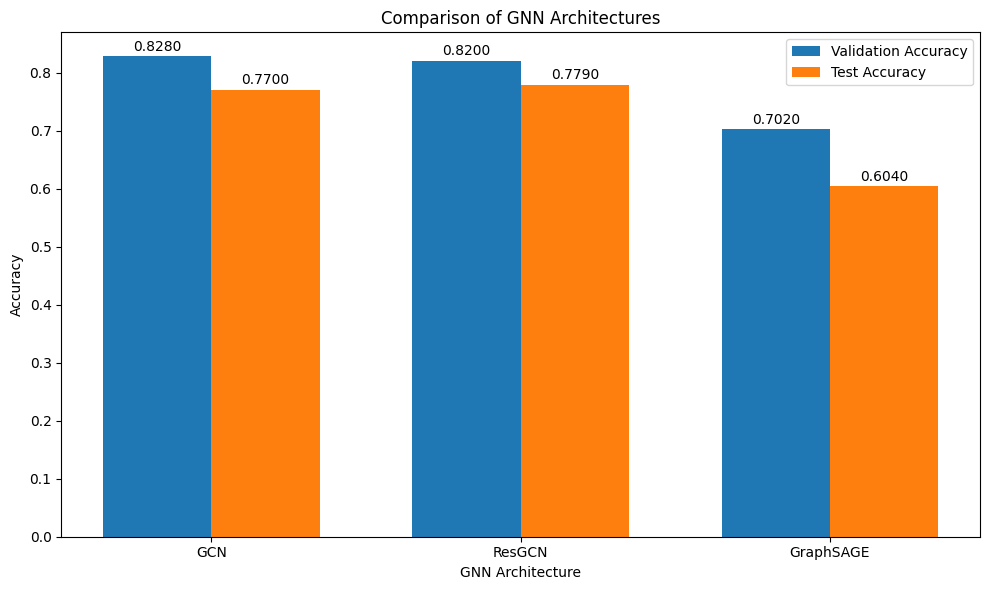

In [38]:
def plot_gnn_comparison(results):
    """
    Plot the results of the GNN architecture comparison.
    
    Parameters
    ----------
    results : dict
        Results from the GNN architecture comparison
    """
    # Extract model names, validation and test accuracies
    models = list(results.keys())
    val_accs = [results[m]['val_acc'] for m in models]
    test_accs = [results[m]['test_acc'] for m in models]
    
    # Create a grouped bar chart
    x = np.arange(len(models))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, val_accs, width, label='Validation Accuracy')
    ax.bar(x + width/2, test_accs, width, label='Test Accuracy')
    
    ax.set_xlabel('GNN Architecture')
    ax.set_ylabel('Accuracy')
    ax.set_title('Comparison of GNN Architectures')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    
    # Add text labels
    for i, v in enumerate(val_accs):
        ax.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center')
    
    for i, v in enumerate(test_accs):
        ax.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center')
    
    plt.tight_layout()
    plt.show()

# Uncomment to plot the comparison results
plot_gnn_comparison(gnn_comparison_results)